In [377]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import networkx as nx
from shapely.geometry import LineString
import os
import math
import matplotlib.cm as cm

In [378]:
food_desert_df = pd.read_csv('./data/FoodDeserts2015.csv')
food_desert_df.head()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga,1,1912,693,0,0,0.000000,0,...,221,1622,217,14,0,14,45,44,26,112
1,1001020200,Alabama,Autauga,1,2170,743,0,181,0.083410,0,...,214,888,1217,5,0,5,55,75,87,202
2,1001020300,Alabama,Autauga,1,3373,1256,0,0,0.000000,0,...,439,2576,647,17,5,11,117,87,108,120
3,1001020400,Alabama,Autauga,1,4386,1722,0,0,0.000000,0,...,904,4086,193,18,4,11,74,85,19,82
4,1001020500,Alabama,Autauga,1,10766,4082,0,181,0.016812,0,...,1126,8666,1437,296,9,48,310,355,198,488


In [379]:
food_desert_df = food_desert_df[['CensusTract', 'State', 'County', 'Urban', 'LALOWI1_20', 'LILATracts_1And20']]
food_desert_df.head()

,CensusTract,State,County,Urban,LALOWI1_20,LILATracts_1And20
0,1001020100,Alabama,Autauga,1,322.084612,0
1,1001020200,Alabama,Autauga,1,145.141418,0
2,1001020300,Alabama,Autauga,1,696.636797,0
3,1001020400,Alabama,Autauga,1,409.587836,0
4,1001020500,Alabama,Autauga,1,623.076555,0


In [380]:
texas_food_desert_df = food_desert_df[food_desert_df['State'] == 'Texas']
texas_food_desert_df.head()

,CensusTract,State,County,Urban,LALOWI1_20,LILATracts_1And20
61468,48001950100,Texas,Anderson,0,0.000000,0
61469,48001950401,Texas,Anderson,0,0.000000,0
61470,48001950402,Texas,Anderson,0,0.000000,0
61471,48001950500,Texas,Anderson,1,1508.448500,1
61472,48001950600,Texas,Anderson,1,1773.149844,1


In [381]:
texas_food_desert_df = texas_food_desert_df[texas_food_desert_df['LILATracts_1And20'] == 1]
texas_food_desert_df.head()

,CensusTract,State,County,Urban,LALOWI1_20,LILATracts_1And20
61471,48001950500,Texas,Anderson,1,1508.448500,1
61472,48001950600,Texas,Anderson,1,1773.149844,1
61488,48005000400,Texas,Angelina,1,930.881586,1
61489,48005000500,Texas,Angelina,1,1356.270450,1
61490,48005000600,Texas,Angelina,1,1384.213758,1


In [382]:
hidalgo_food_desert_df = texas_food_desert_df[texas_food_desert_df['County'] == 'Hidalgo']
hidalgo_food_desert_df

,CensusTract,State,County,Urban,LALOWI1_20,LILATracts_1And20
64590,48215020101,Texas,Hidalgo,1,1816.770445,1
64591,48215020102,Texas,Hidalgo,1,2759.379864,1
64592,48215020201,Texas,Hidalgo,1,764.808921,1
64593,48215020202,Texas,Hidalgo,1,581.470155,1
64594,48215020204,Texas,Hidalgo,1,1886.746707,1
64595,48215020205,Texas,Hidalgo,1,1506.272732,1
64601,48215020501,Texas,Hidalgo,1,1011.366550,1
64602,48215020503,Texas,Hidalgo,1,7156.301170,1
64603,48215020504,Texas,Hidalgo,1,3974.120054,1
64610,48215020726,Texas,Hidalgo,1,208.060269,1


In [383]:
texas_geo_df = gpd.read_file('./data/2015_CensusTract/tl_2015_48_tract.shp')
texas_geo_df = texas_geo_df.to_crs("EPSG:4326")
texas_geo_df.iloc[0,:]

STATEFP                                                    48
COUNTYFP                                                  201
TRACTCE                                                542301
GEOID                                             48201542301
NAME                                                  5423.01
NAMELSAD                                 Census Tract 5423.01
MTFCC                                                   G5020
FUNCSTAT                                                    S
ALAND                                                 5956745
AWATER                                                  15456
INTPTLAT                                          +29.8204990
INTPTLON                                         -095.7316493
geometry    POLYGON ((-95.75223799999999 29.83168599999999...
Name: 0, dtype: object

In [384]:
# Load Hidalgo from GeoPandas
hidalgo_geo_df = texas_geo_df[texas_geo_df['COUNTYFP'] == '215']

In [385]:
# Ensure IDs are string type
texas_geo_df = texas_geo_df.copy()
texas_geo_df['GEOID'] = texas_geo_df['GEOID'].astype(str)

texas_food_desert_df = texas_food_desert_df.copy()
texas_food_desert_df['CensusTract'] = texas_food_desert_df['CensusTract'].astype(str)

# Extract GEOID and coordinates
geo_latlon_df = texas_geo_df[['GEOID', 'INTPTLAT', 'INTPTLON']]

# Filter for Hidalgo County
hidalgo_food_desert_df = texas_food_desert_df[texas_food_desert_df['County'] == 'Hidalgo']

In [386]:
# Merge to get lat/lon
hidalgo_food_desert_df = hidalgo_food_desert_df.merge(
    geo_latlon_df,
    left_on='CensusTract',
    right_on='GEOID',
    how='inner'
)

In [387]:
hidalgo_food_desert_df = hidalgo_food_desert_df.drop(columns=['LILATracts_1And20'])

In [388]:
hidalgo_food_desert_df.head()

,CensusTract,State,County,Urban,LALOWI1_20,GEOID,INTPTLAT,INTPTLON
0,48215020101,Texas,Hidalgo,1,1816.770445,48215020101,+26.2109434,-098.3390991
1,48215020102,Texas,Hidalgo,1,2759.379864,48215020102,+26.1682870,-098.3504156
2,48215020201,Texas,Hidalgo,1,764.808921,48215020201,+26.2376537,-098.3848948
3,48215020202,Texas,Hidalgo,1,581.470155,48215020202,+26.2334689,-098.3585402
4,48215020204,Texas,Hidalgo,1,1886.746707,48215020204,+26.2362175,-098.3347339


## LILA Clusters in Hidalgo

In [389]:
# Convert lat/lon to numeric (remove '+' if present and convert)
hidalgo_food_desert_df['LAT'] = hidalgo_food_desert_df['INTPTLAT'].astype(str).str.replace('+', '', regex=False).astype(float)
hidalgo_food_desert_df['LON'] = hidalgo_food_desert_df['INTPTLON'].astype(str).astype(float)

# Prepare the data for clustering
coords = hidalgo_food_desert_df[['LAT', 'LON']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
hidalgo_food_desert_df['cluster'] = kmeans.fit_predict(coords)

# Preview result
hidalgo_food_desert_df[['GEOID', 'LAT', 'LON', 'cluster']].head()

,GEOID,LAT,LON,cluster
0,48215020101,26.210943,-98.339099,1
1,48215020102,26.168287,-98.350416,1
2,48215020201,26.237654,-98.384895,1
3,48215020202,26.233469,-98.358540,1
4,48215020204,26.236217,-98.334734,1


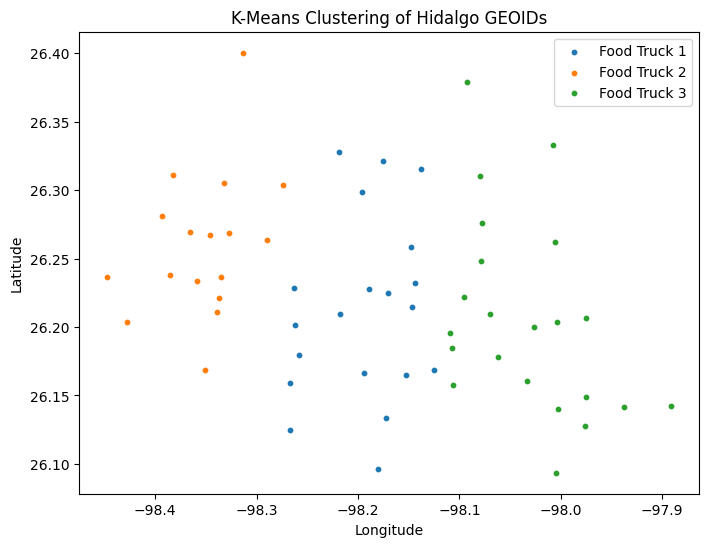

In [390]:
plt.figure(figsize=(8, 6))
for cluster in range(3):
    cluster_data = hidalgo_food_desert_df[hidalgo_food_desert_df['cluster'] == cluster]
    plt.scatter(cluster_data['LON'], cluster_data['LAT'], label=f'Food Truck {cluster + 1}', s=10)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Hidalgo GEOIDs')
plt.legend()
plt.show()

In [439]:
cluster_counts = hidalgo_food_desert_df.groupby('cluster')['GEOID'].nunique().reset_index()
cluster_counts.columns = ['cluster', 'num_geoids']
cluster_counts

,cluster,num_geoids
0,0,20
1,1,17
2,2,22


## Select highest-population node per cluster

In [392]:
# Ensure LALOWI1_20 is numeric
hidalgo_food_desert_df['LALOWI1_20'] = hidalgo_food_desert_df['LALOWI1_20'].astype(int)

# Get the row with the max population in each cluster
top_nodes_df = hidalgo_food_desert_df.loc[hidalgo_food_desert_df.groupby('cluster')['LALOWI1_20'].idxmax()]

# Preview
print(top_nodes_df[['cluster', 'GEOID', 'LALOWI1_20', 'LAT', 'LON']])

    cluster        GEOID  LALOWI1_20        LAT        LON
7         0  48215020503        7156  26.159350 -98.266600
52        1  48215024112       11182  26.400457 -98.313570
41        2  48215023515        7660  26.275813 -98.077555


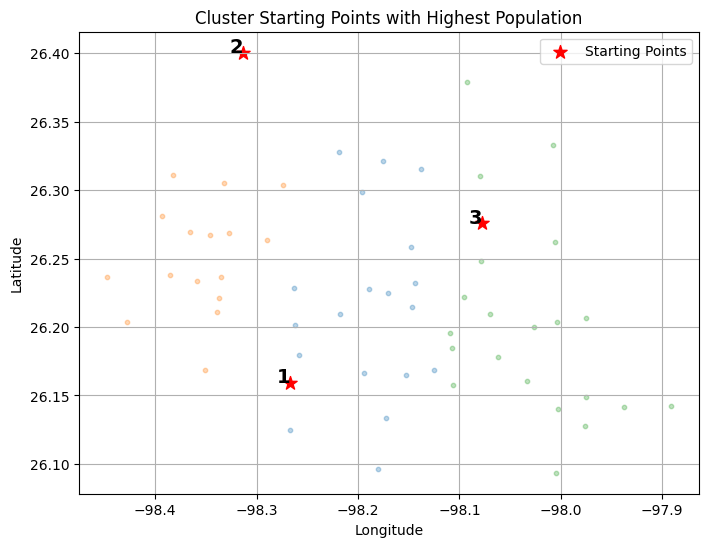

In [393]:
plt.figure(figsize=(8, 6))

# Plot all points with faint colors (but no legend for clusters)
for label in sorted(hidalgo_food_desert_df['cluster'].unique()):
    group = hidalgo_food_desert_df[hidalgo_food_desert_df['cluster'] == label]
    plt.scatter(group['LON'], group['LAT'], s=10, alpha=0.3, label='_nolegend_')

# Overlay starting points
plt.scatter(top_nodes_df['LON'], top_nodes_df['LAT'], c='red', s=100, label='Starting Points', marker='*')

# Annotate clusters
for _, row in top_nodes_df.iterrows():
    plt.text(row['LON'], row['LAT'], f'{row["cluster"] + 1}', fontsize=14, ha='right', fontweight='bold')

plt.title('Cluster Starting Points with Highest Population')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

In [394]:
# Filter to LILA tracts only
lila_geo_df = hidalgo_geo_df[hidalgo_geo_df['GEOID'].isin(hidalgo_food_desert_df['CensusTract'])].copy()
lila_geo_df = lila_geo_df.to_crs(epsg=3081)
# Get centroids
lila_geo_df['centroid'] = lila_geo_df.geometry.centroid

In [395]:
hidalgo_geo_df_proj = hidalgo_geo_df.to_crs(epsg=3081)
# Merge cluster labels into the shapefile
hidalgo_geo_df_proj = hidalgo_geo_df_proj.merge(
    hidalgo_food_desert_df[['CensusTract', 'cluster']],
    left_on='GEOID',
    right_on='CensusTract',
    how='left'
)

In [396]:
# Define a color for each cluster/food truck
num_clusters = hidalgo_food_desert_df['cluster'].nunique()
cluster_colors = plt.cm.get_cmap('tab10', num_clusters)  # or use 'Set3', 'tab20', etc.

# Map each cluster to a color
cluster_color_map = {i: cluster_colors(i) for i in range(num_clusters)}
hidalgo_geo_df_proj['cluster_color'] = hidalgo_geo_df_proj['cluster'].map(cluster_color_map)

C:\Users\eomar\AppData\Local\Temp\ipykernel_51948\3016997490.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', num_clusters)  # or use 'Set3', 'tab20', etc.


In [397]:
lila_clusters = hidalgo_geo_df_proj[hidalgo_geo_df_proj['GEOID'].isin(lila_geo_df['GEOID'])].copy()

In [398]:
# Convert top_nodes_df to GeoDataFrame using LAT and LON
top_nodes_df = gpd.GeoDataFrame(
    top_nodes_df,
    geometry=gpd.points_from_xy(top_nodes_df['LON'], top_nodes_df['LAT']),
    crs="EPSG:4326"
)

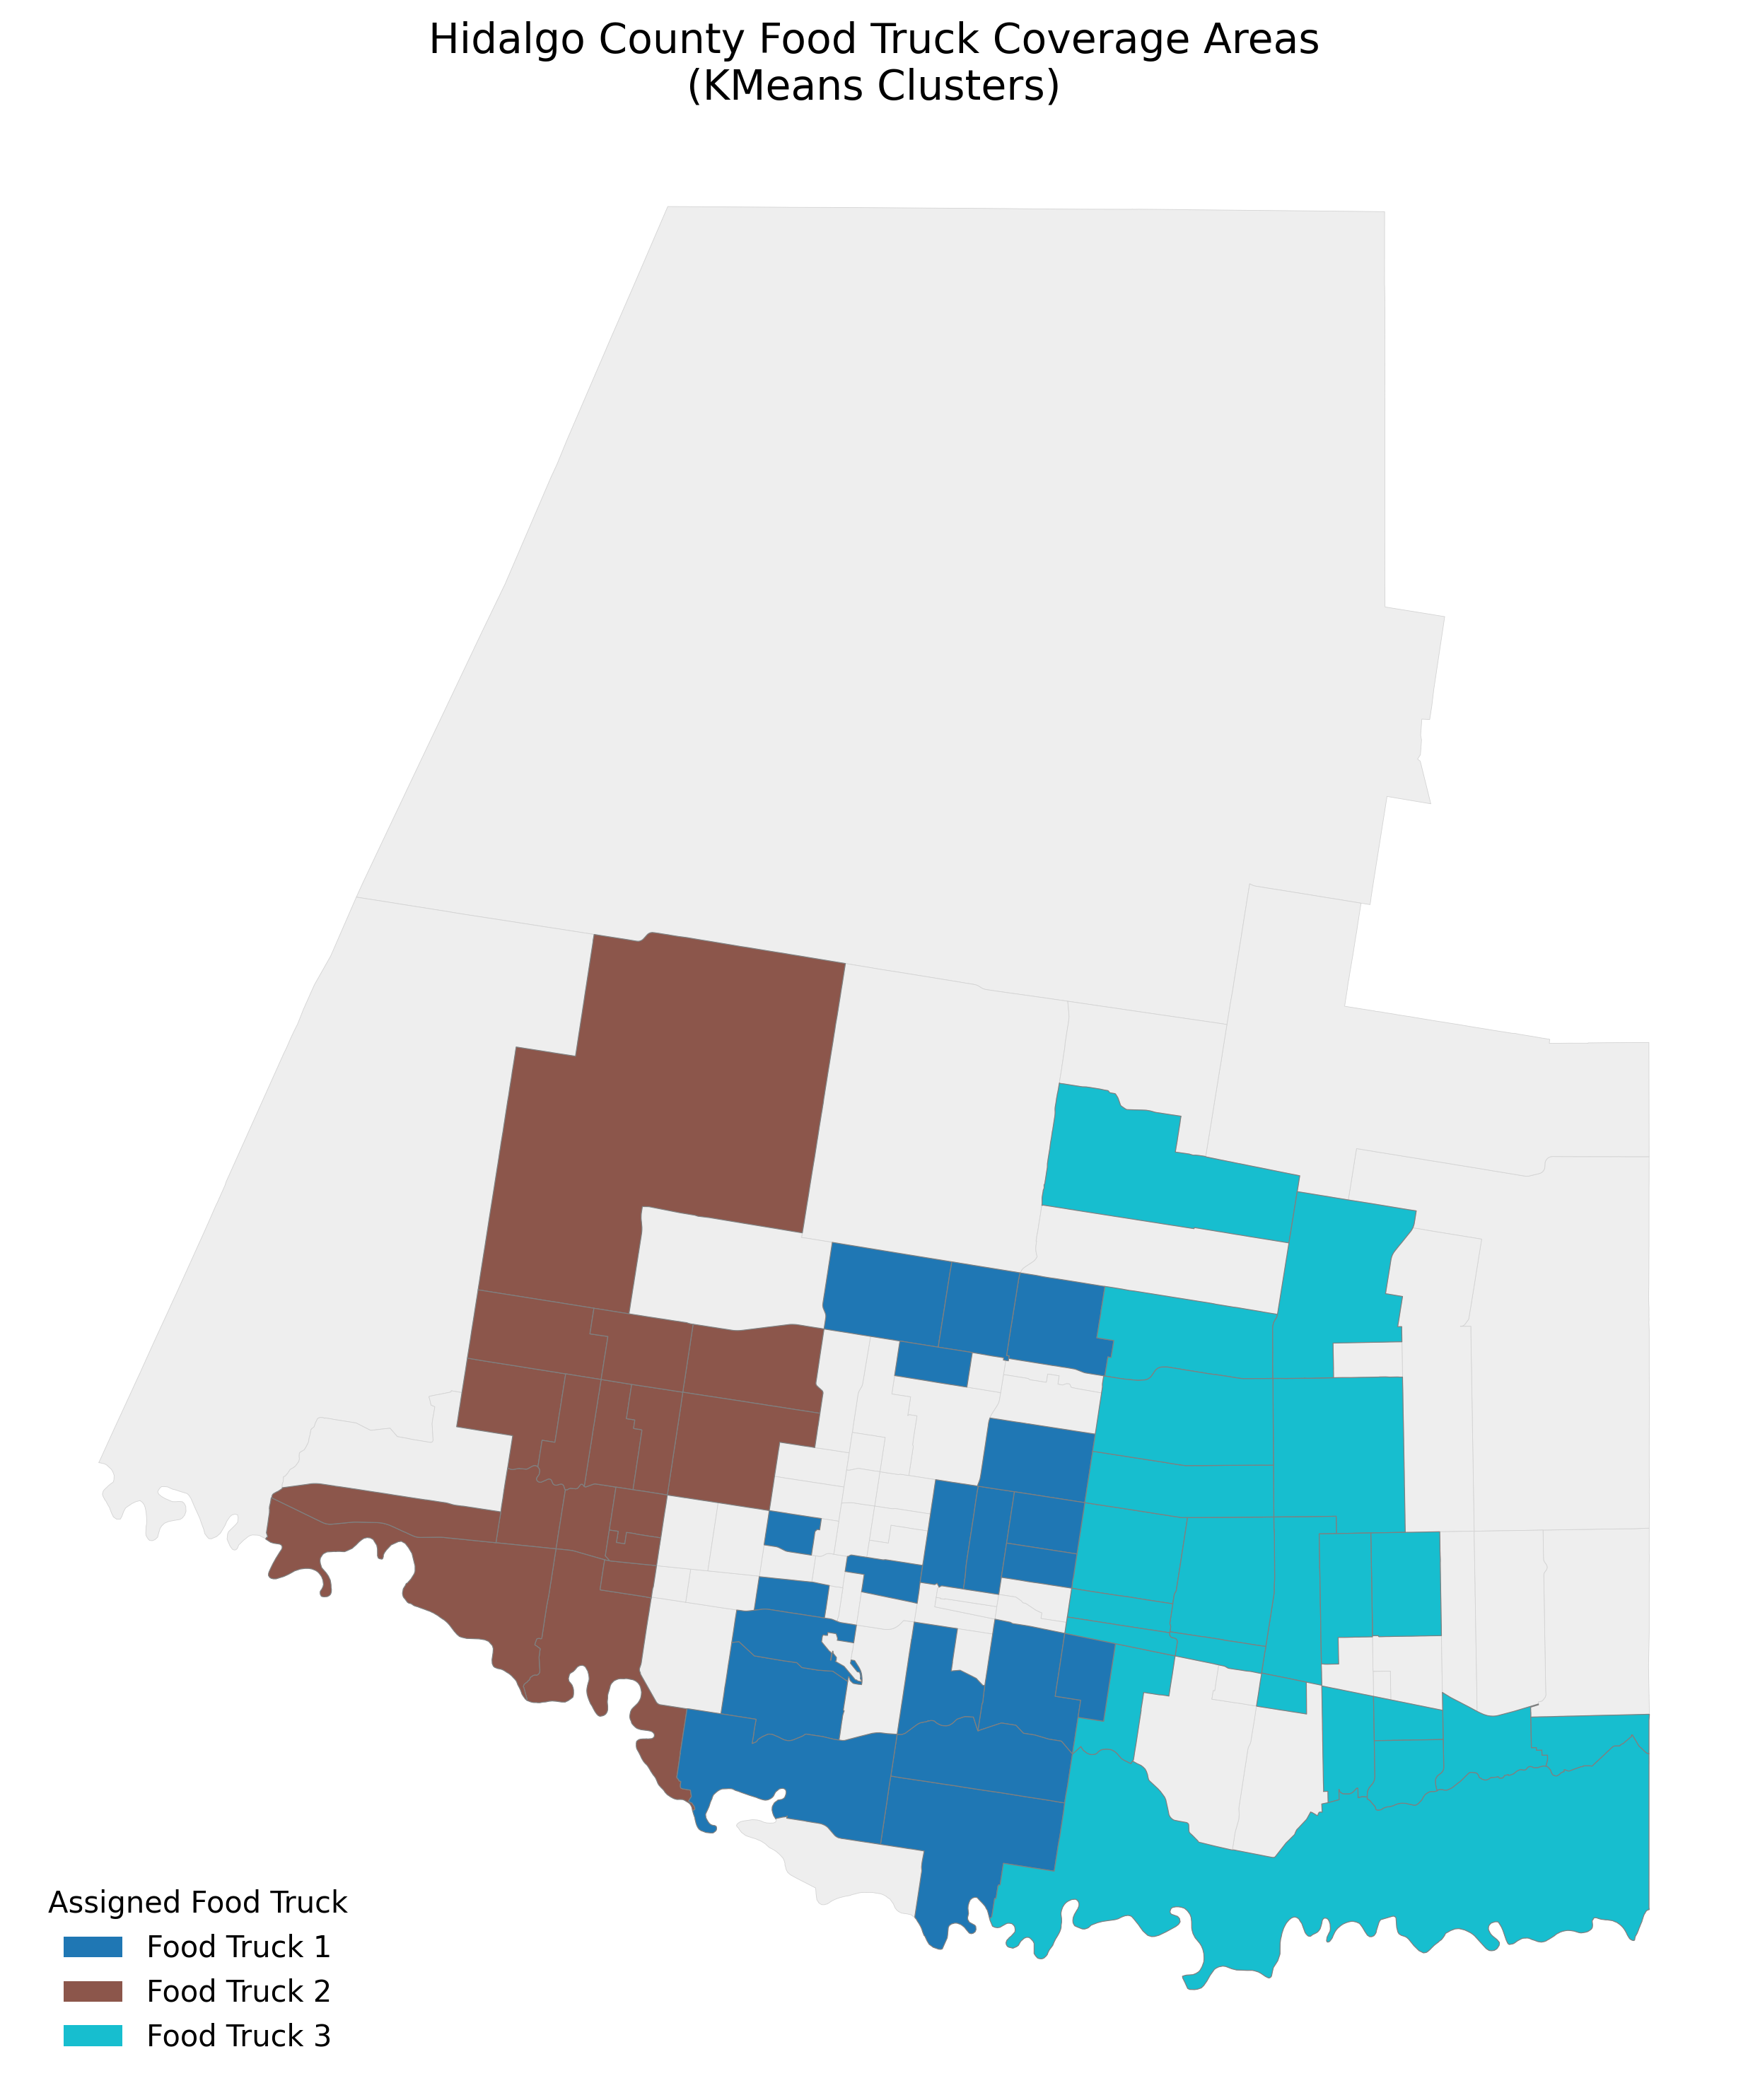

In [399]:
# Reproject Hidalgo shapefile if needed
hidalgo_geo_df_proj = hidalgo_geo_df.to_crs(epsg=3857)
lila_clusters = lila_clusters.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
plt.title('Hidalgo County Food Truck Coverage Areas\n(KMeans Clusters)', fontsize=14)

# Base map of Hidalgo in gray
hidalgo_geo_df_proj.plot(
    ax=ax,
    color='#eeeeee',
    edgecolor='lightgray',
    linewidth=0.2
)

# LILA tracts shaded by assigned cluster color
lila_clusters.plot(
    ax=ax,
    color=lila_clusters['cluster_color'],
    edgecolor='gray',
    linewidth=0.3
)

# Legend
legend_elements = [
    Patch(facecolor=cluster_colors(i), label=f'Food Truck {i + 1}')
    for i in range(num_clusters)
]

plt.legend(
    handles=legend_elements,
    title='Assigned Food Truck',
    loc='lower left',
    frameon=False
)

plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\eomar\AppData\Local\Temp\ipykernel_51948\1904469486.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', num_clusters)


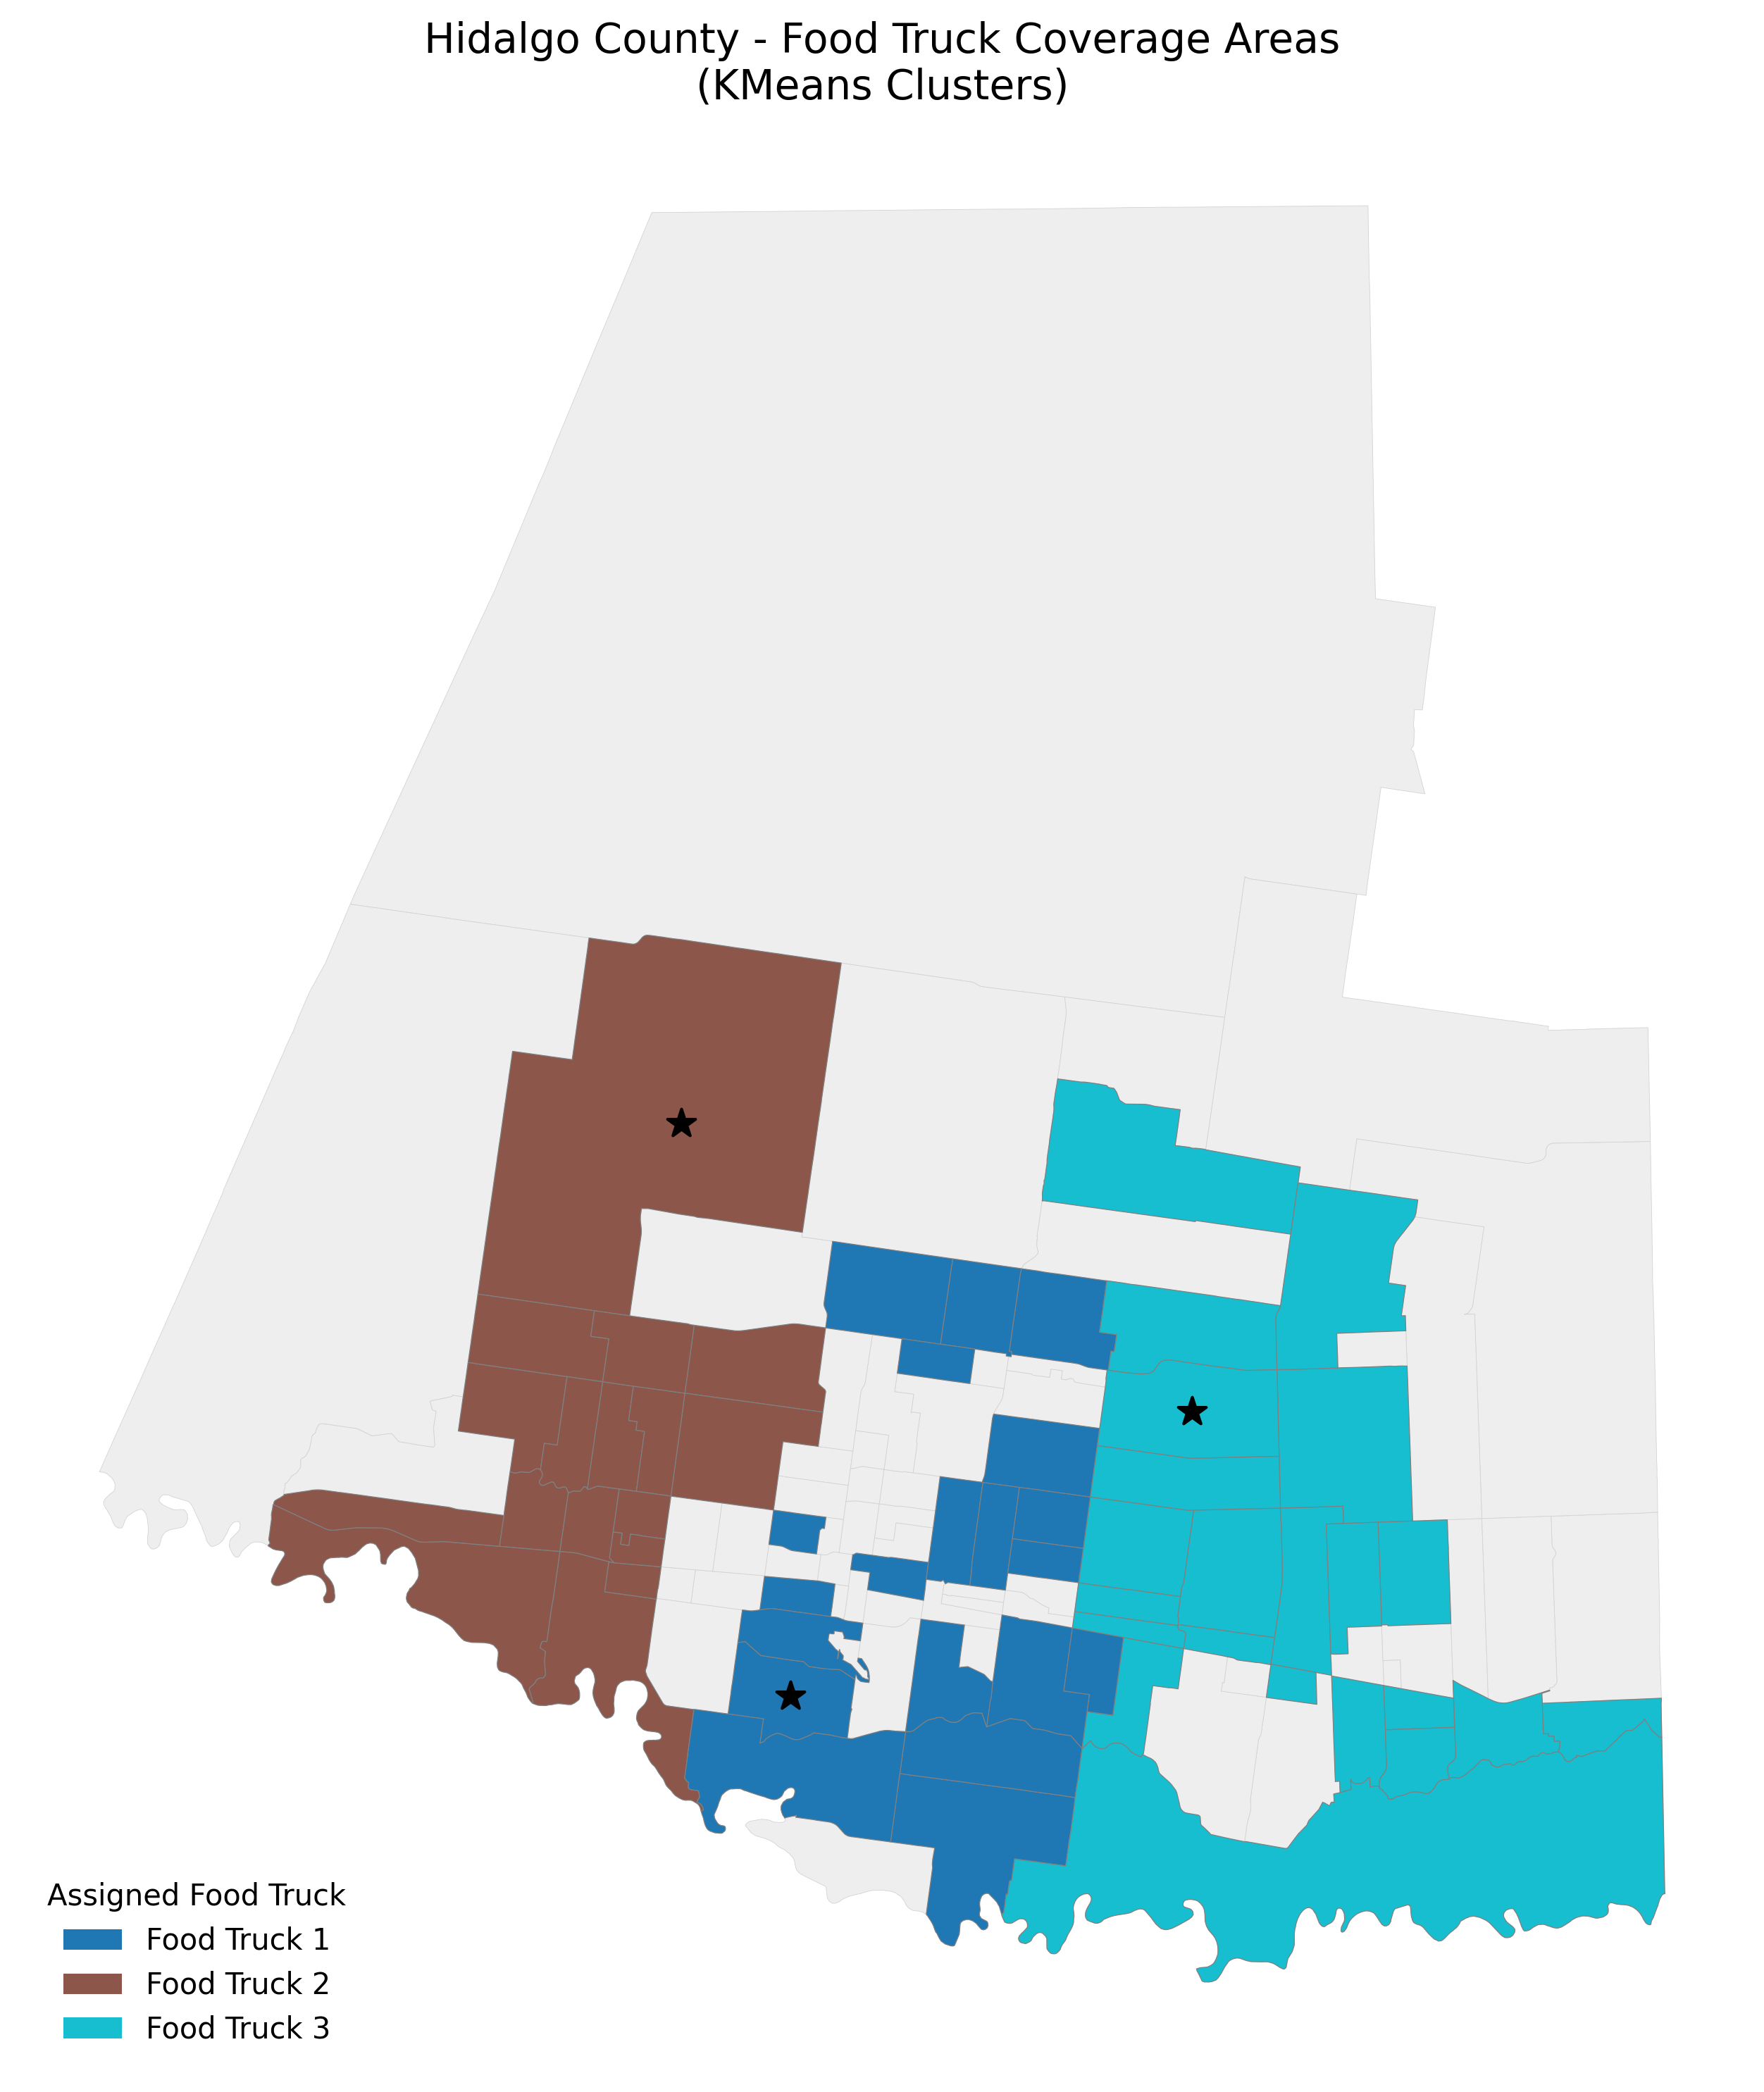

In [400]:
# Filter both datasets to just Hidalgo County
hidalgo_geo_df = texas_geo_df[texas_geo_df['COUNTYFP'] == '215'].copy()

# Project to local coordinate system
hidalgo_geo_df = hidalgo_geo_df.to_crs(epsg=3081)

# Keep only LILA tracts
lila_geo_df = hidalgo_geo_df[hidalgo_geo_df['GEOID'].isin(hidalgo_food_desert_df['CensusTract'])].copy()

# Get centroids
lila_geo_df['centroid'] = lila_geo_df.geometry.centroid

# Merge cluster labels into the shapefile
hidalgo_geo_df = hidalgo_geo_df.merge(
    hidalgo_food_desert_df[['CensusTract', 'cluster']],
    left_on='GEOID',
    right_on='CensusTract',
    how='left'
)

# Define cluster colors
num_clusters = hidalgo_food_desert_df['cluster'].nunique()
cluster_colors = plt.cm.get_cmap('tab10', num_clusters)
cluster_color_map = {i: cluster_colors(i) for i in range(num_clusters)}

# Assign colors to the tracts
hidalgo_geo_df['cluster_color'] = hidalgo_geo_df['cluster'].map(cluster_color_map)
hidalgo_food_desert_df['cluster_color'] = hidalgo_food_desert_df['cluster'].map(cluster_color_map)
# Keep only the LILA tracts again with cluster colors
lila_clusters = hidalgo_geo_df[hidalgo_geo_df['GEOID'].isin(lila_geo_df['GEOID'])].copy()

# Convert top_nodes_df to GeoDataFrame (assuming LAT/LON are in EPSG:4326)
top_nodes_df = gpd.GeoDataFrame(
    top_nodes_df,
    geometry=gpd.points_from_xy(top_nodes_df['LON'], top_nodes_df['LAT']),
    crs="EPSG:4326"
).to_crs(epsg=3081)  # Reproject to match map

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
plt.title('Hidalgo County - Food Truck Coverage Areas\n(KMeans Clusters)', fontsize=14)

# Plot base map of Hidalgo County
hidalgo_geo_df.plot(
    ax=ax,
    color='#eeeeee',
    edgecolor='lightgray',
    linewidth=0.2
)

# Plot colored LILA tracts
lila_clusters.plot(
    ax=ax,
    color=lila_clusters['cluster_color'],
    edgecolor='gray',
    linewidth=0.3
)

# Add cluster centroids
top_nodes_df.plot(ax=ax, color='black', marker='*', markersize=100, label='Cluster Center')

# Custom legend
legend_elements = [
    Patch(facecolor=cluster_colors(i), label=f'Food Truck {i + 1}')
    for i in range(num_clusters)
]

plt.legend(
    handles=legend_elements,
    title='Assigned Food Truck',
    loc='lower left',
    frameon=False
)

plt.axis('off')
plt.tight_layout()
plt.show()

## Save Edges

In [401]:
# Prepare dataframe and coordinates
df = hidalgo_food_desert_df.copy()
df['LAT'] = df['INTPTLAT'].astype(float)
df['LON'] = df['INTPTLON'].astype(float)

# Container to hold all edges
all_edges = []

# Loop through each cluster (Food Truck = cluster_id + 1)
for cluster_id in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster_id].reset_index(drop=True)

    coords = cluster_df[['LAT', 'LON']].to_numpy()
    geoids = cluster_df['GEOID'].astype(str).tolist()

    # Skip small clusters
    if len(coords) <= 1:
        print(f"Skipping cluster {cluster_id + 1} (only {len(coords)} point)")
        continue

    # Compute full pairwise haversine distances
    for i in range(len(coords)):
        for j in range(len(coords)):
            if i == j:
                continue  # skip self-loops

            lat1, lon1 = np.radians(coords[i])
            lat2, lon2 = np.radians(coords[j])
            dlat = lat2 - lat1
            dlon = lon2 - lon1

            a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
            c = 2 * np.arcsin(np.sqrt(a))
            dist_miles = 3958.8 * c  # Earth's radius in miles

            node1 = geoids[i]
            node2 = geoids[j]
            all_edges.append((cluster_id + 1, node1, node2, dist_miles))  # +1 for 1-based indexing

# Create DataFrame
edges_df = pd.DataFrame(all_edges, columns=['Food Truck', 'Source', 'Target', 'Distance_miles'])

# Save to file
edges_df.to_csv('./data/texas/hidalgo_pairwise_edges.csv', index=False)
print(f"✅ Saved {len(edges_df)} pairwise edges to 'hidalgo_pairwise_edges.csv'")

✅ Saved 1114 pairwise edges to 'hidalgo_pairwise_edges.csv'


## Creating the graph

In [402]:
# Load original node coordinates
df = hidalgo_food_desert_df.copy()
df['LAT'] = df['INTPTLAT'].astype(float)
df['LON'] = df['INTPTLON'].astype(float)
geoid_coords = df.set_index('GEOID')[['LON', 'LAT']].to_dict('index')  # for (x, y) mapping

# Create graph
G = nx.Graph()
for _, row in edges_df.iterrows():
    src = row['Source']
    tgt = row['Target']
    dist = row['Distance_miles']
    truck = row['Food Truck']
    G.add_edge(src, tgt, weight=dist, food_truck=truck)

In [403]:
# Number of nodes and edges
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

# Print edge data example
print(list(G.edges(data=True))[:5])

Nodes: 59
Edges: 557
[('48215020501', '48215020503', {'weight': 2.909924738838187, 'food_truck': 1}), ('48215020501', '48215020504', {'weight': 1.5157169968988828, 'food_truck': 1}), ('48215020501', '48215020726', {'weight': 1.8706933791480718, 'food_truck': 1}), ('48215020501', '48215021000', {'weight': 2.811403015057001, 'food_truck': 1}), ('48215020501', '48215021302', {'weight': 7.294336453132324, 'food_truck': 1})]


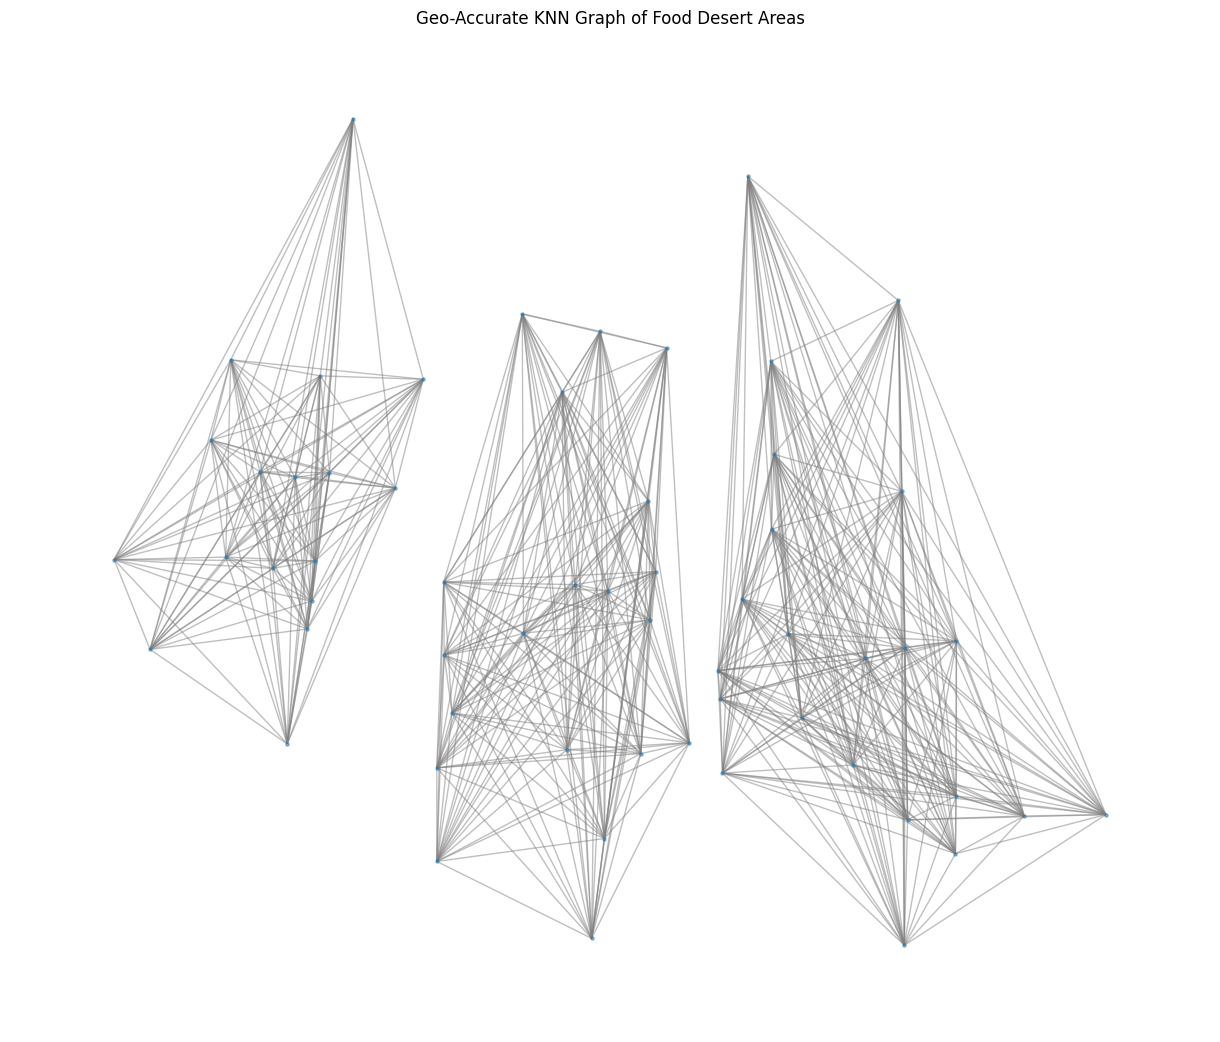

In [404]:
# Create position dict using LON for x and LAT for y
pos = {geoid: (coords['LON'], coords['LAT']) for geoid, coords in geoid_coords.items() if geoid in G.nodes}

plt.figure(figsize=(12, 10))
nx.draw(
    G,
    pos=pos,
    node_size=5,
    edge_color='gray',
    alpha=0.5,
    with_labels=False
)
plt.title('Geo-Accurate KNN Graph of Food Desert Areas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

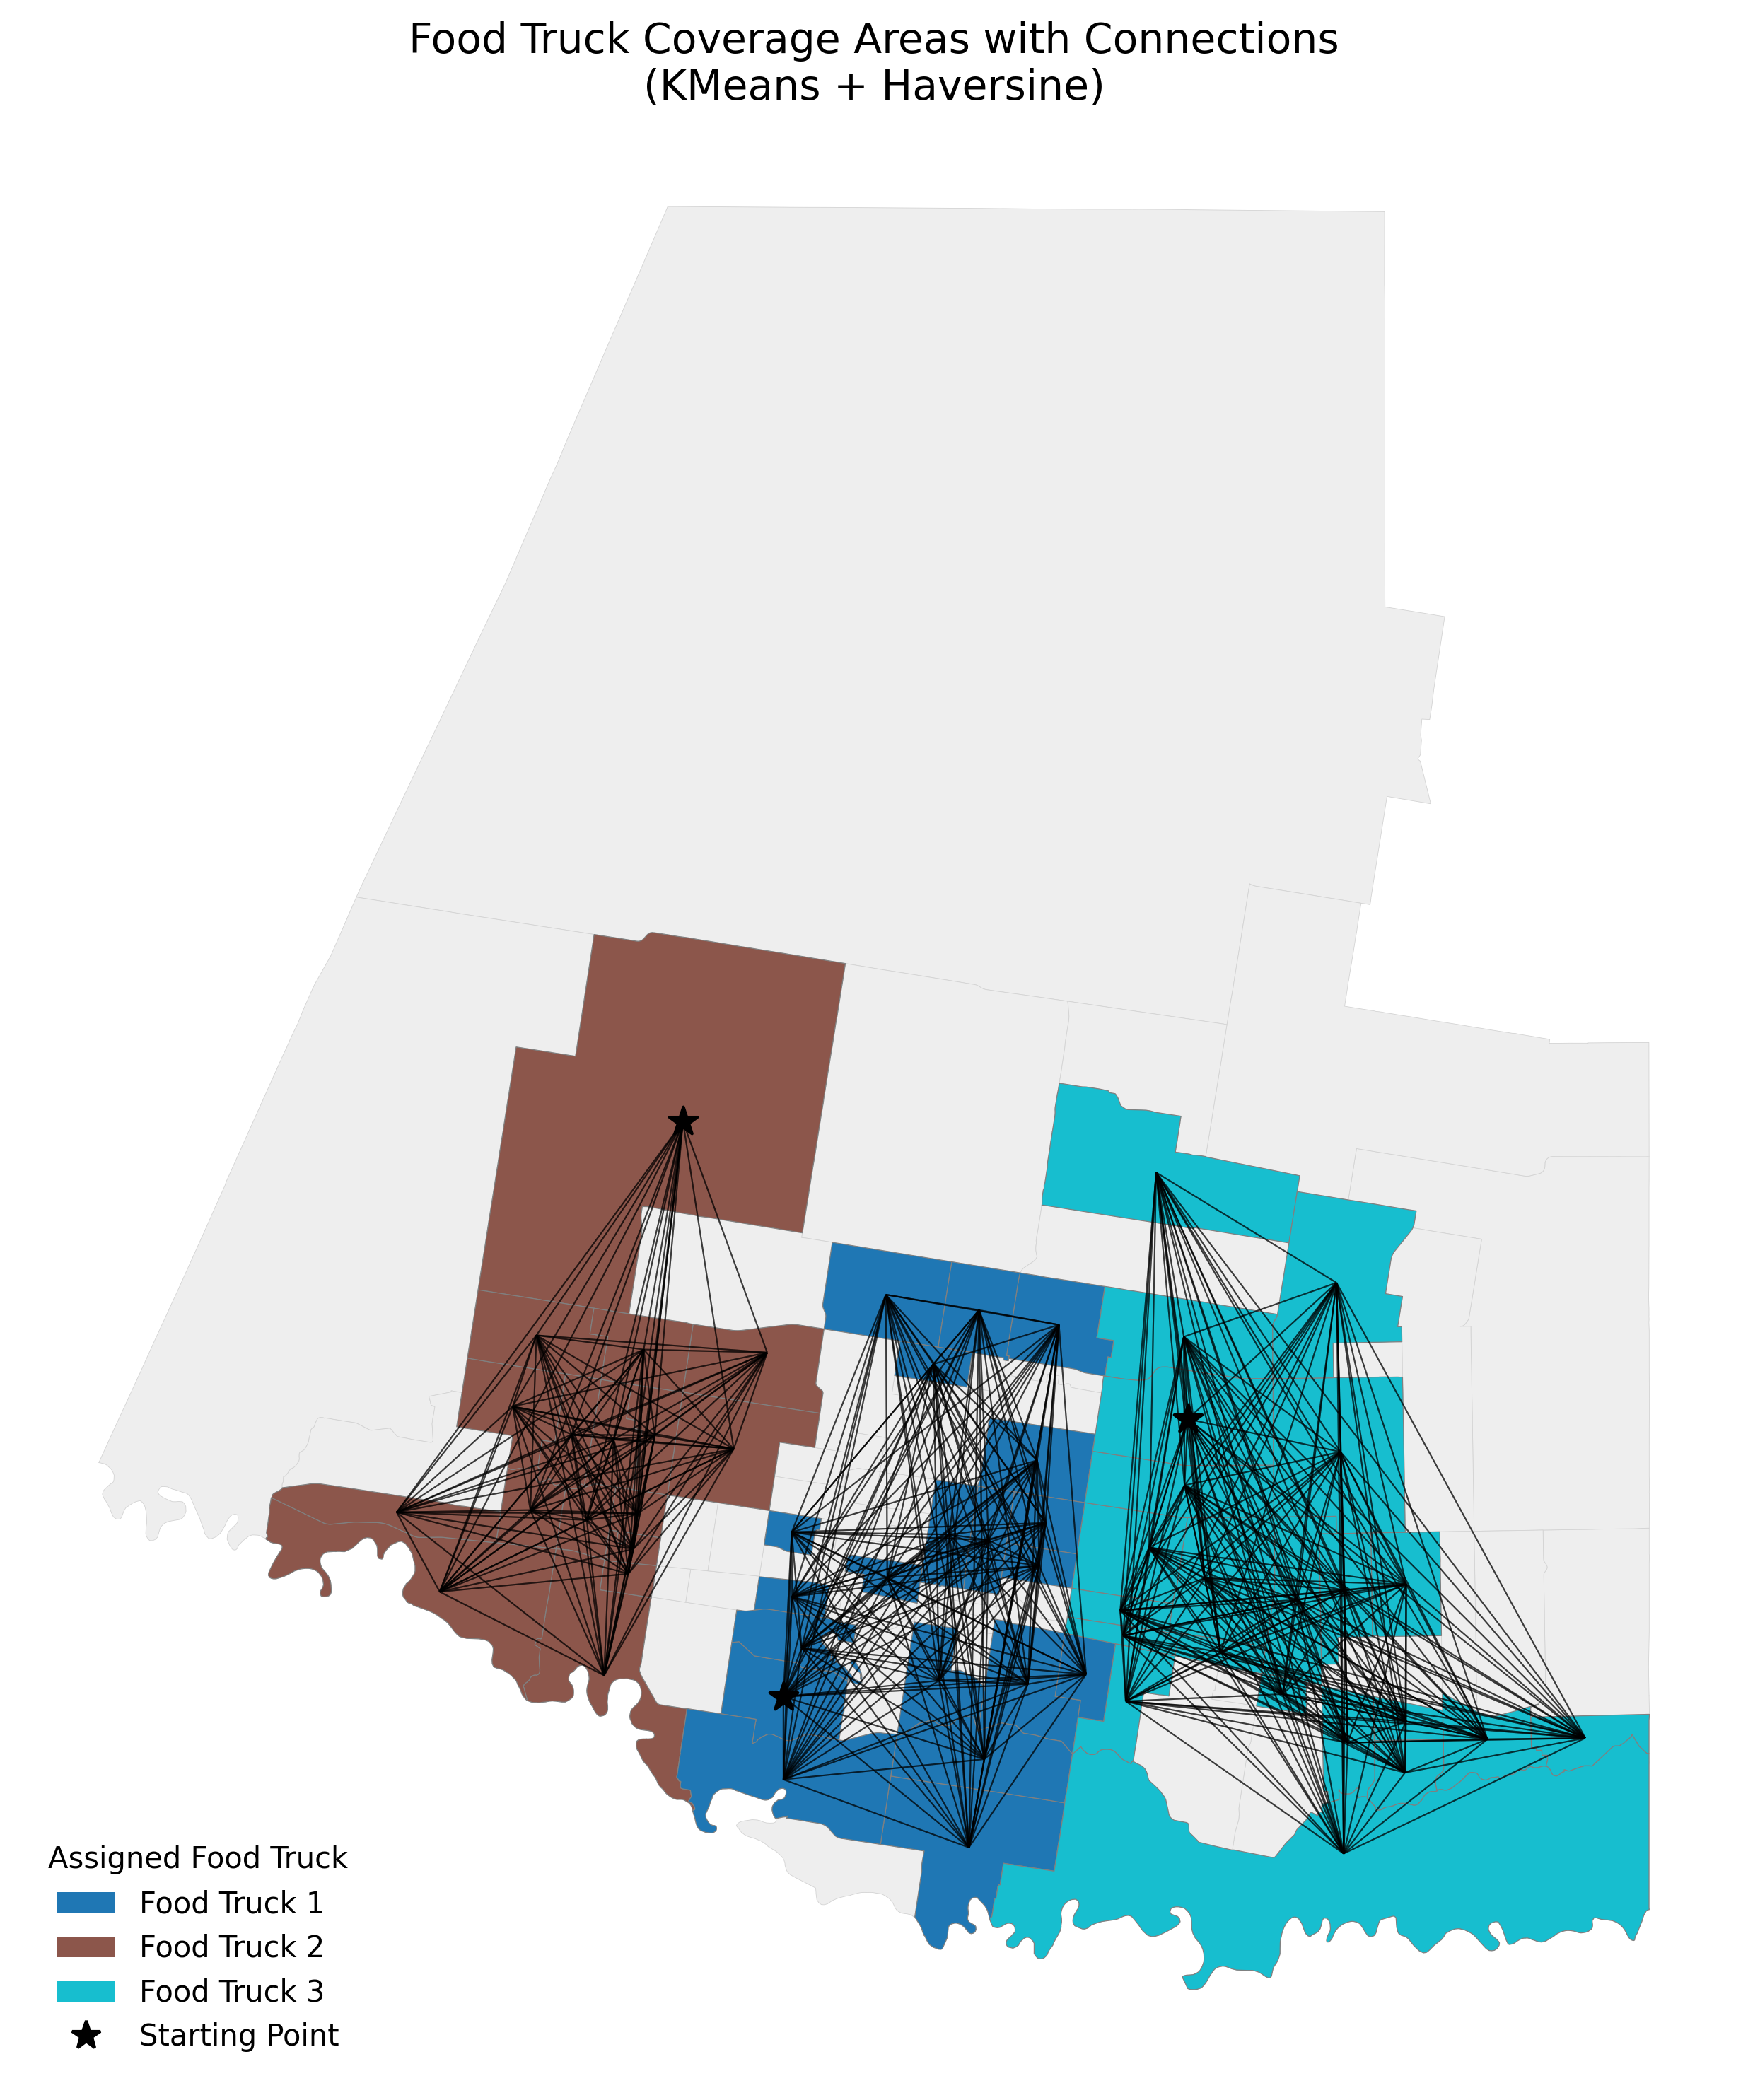

In [405]:
# === Step 1: Prepare base node GeoDataFrame ===
df = hidalgo_food_desert_df.copy()
df['LAT'] = df['INTPTLAT'].astype(float)
df['LON'] = df['INTPTLON'].astype(float)
df['GEOID'] = df['GEOID'].astype(str)

nodes_gdf = gpd.GeoDataFrame(
    df[['GEOID', 'cluster']],
    geometry=gpd.points_from_xy(df['LON'], df['LAT']),
    crs='EPSG:4326'
).to_crs(epsg=3857)

geoid_to_point = dict(zip(nodes_gdf['GEOID'], nodes_gdf.geometry))

# === Step 2: Load and build edges_gdf ===
edges_df = pd.read_csv('./data/texas/hidalgo_pairwise_edges.csv')
edges_df['Source'] = edges_df['Source'].astype(str)
edges_df['Target'] = edges_df['Target'].astype(str)

edge_geometries = [
    LineString([geoid_to_point[src], geoid_to_point[tgt]])
    for src, tgt in zip(edges_df['Source'], edges_df['Target'])
    if src in geoid_to_point and tgt in geoid_to_point
]

edges_gdf = gpd.GeoDataFrame(edges_df.loc[:len(edge_geometries)-1].copy(), geometry=edge_geometries, crs='EPSG:3857')

# === Step 3: Prepare top_nodes_gdf ===
top_nodes_df['LAT'] = top_nodes_df['INTPTLAT'].astype(float)
top_nodes_df['LON'] = top_nodes_df['INTPTLON'].astype(float)
top_nodes_df['GEOID'] = top_nodes_df['GEOID'].astype(str)

top_nodes_gdf = gpd.GeoDataFrame(
    top_nodes_df[['GEOID', 'cluster']],
    geometry=gpd.points_from_xy(top_nodes_df['LON'], top_nodes_df['LAT']),
    crs='EPSG:4326'
).to_crs(epsg=3857)

# === Step 4: Project tracts if not already ===
lila_clusters = lila_clusters.to_crs(epsg=3857)
hidalgo_geo_df_proj = hidalgo_geo_df_proj.to_crs(epsg=3857)

# === Step 5: Plot everything ===
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
plt.title('Food Truck Coverage Areas with Connections\n(KMeans + Haversine)', fontsize=14)

# Background
hidalgo_geo_df_proj.plot(ax=ax, color='#eeeeee', edgecolor='lightgray', linewidth=0.2)

# LILA tracts shaded by cluster
lila_clusters.plot(ax=ax, color=lila_clusters['cluster_color'], edgecolor='gray', linewidth=0.3)

# KNN connections
edges_gdf.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5)

# Starting points as stars
top_nodes_gdf.plot(ax=ax, color='black', marker='*', markersize=100, label='Starting Point')

# Legend
legend_elements = [
    Patch(facecolor=cluster_colors(i), label=f'Food Truck {i + 1}')
    for i in range(num_clusters)
] + [
    Line2D([0], [0], marker='*', color='black', label='Starting Point', markersize=10, linestyle='None')
]

plt.legend(
    handles=legend_elements,
    title='Assigned Food Truck',
    loc='lower left',
    frameon=False
)

plt.axis('off')
plt.tight_layout()
plt.show()

In [406]:
# === Step 1: Ensure CRS and types are clean ===
hidalgo_geo_df = hidalgo_geo_df.to_crs(epsg=3857)
lila_clusters = lila_clusters.to_crs(epsg=3857)
lila_clusters['cluster'] = lila_clusters['cluster'].astype(int)
top_nodes_df['cluster'] = top_nodes_df['cluster'].astype(int)

# === Step 2: Prepare top node GeoDataFrame ===
top_nodes_df['LAT'] = top_nodes_df['INTPTLAT'].astype(float)
top_nodes_df['LON'] = top_nodes_df['INTPTLON'].astype(float)
top_nodes_df['GEOID'] = top_nodes_df['GEOID'].astype(str)

top_nodes_gdf = gpd.GeoDataFrame(
    top_nodes_df[['GEOID', 'cluster']],
    geometry=gpd.points_from_xy(top_nodes_df['LON'], top_nodes_df['LAT']),
    crs='EPSG:4326'
).to_crs(epsg=3857)

# === Step 3: Make output folder ===
output_folder = "./maps_per_cluster_hidalgo"
os.makedirs(output_folder, exist_ok=True)

# === Step 4: Loop through clusters and plot each ===
for cluster_id in sorted(lila_clusters['cluster'].unique()):
    # Filter tracts and cluster center
    cluster_tracts = lila_clusters[lila_clusters['cluster'] == cluster_id]
    cluster_start = top_nodes_gdf[top_nodes_gdf['cluster'] == cluster_id]

    # Set up figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
    plt.title(f'Hidalgo Food Truck {cluster_id + 1} Coverage Area', fontsize=14)

    # Plot base map of Hidalgo
    hidalgo_geo_df.plot(ax=ax, color='#eeeeee', edgecolor='lightgray', linewidth=0.2)

    # Plot cluster tracts
    cluster_tracts.plot(ax=ax, color=cluster_tracts['cluster_color'], edgecolor='gray', linewidth=0.3)

    # Plot starting point (star)
    cluster_start.plot(ax=ax, color='black', marker='*', markersize=150)

    # Zoom into the cluster area
    bounds = cluster_tracts.total_bounds
    ax.set_xlim(bounds[0] - 10000, bounds[2] + 10000)
    ax.set_ylim(bounds[1] - 10000, bounds[3] + 10000)

    # Clean layout
    ax.axis('off')
    plt.tight_layout()

    # Save image
    filename = f"{output_folder}/food_truck_{cluster_id + 1}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

    print(f"✅ Saved: {filename}")

✅ Saved: ./maps_per_cluster_hidalgo/food_truck_1.png
✅ Saved: ./maps_per_cluster_hidalgo/food_truck_2.png
✅ Saved: ./maps_per_cluster_hidalgo/food_truck_3.png


In [407]:
hidalgo_food_desert_df.columns

Index(['CensusTract', 'State', 'County', 'Urban', 'LALOWI1_20', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'LAT', 'LON', 'cluster', 'cluster_color'],
      dtype='object')

In [408]:
lila_clusters.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'CensusTract', 'cluster', 'cluster_color'],
      dtype='object')

In [409]:
edges_df.columns

Index(['Food Truck', 'Source', 'Target', 'Distance_miles'], dtype='object')

## TSP

In [436]:

# Setup summary results container
summary = []

# Convert GEOIDs to string for consistency
edges_df['Source'] = edges_df['Source'].astype(str)
edges_df['Target'] = edges_df['Target'].astype(str)
hidalgo_food_desert_df['GEOID'] = hidalgo_food_desert_df['GEOID'].astype(str)

In [437]:
output_folder = "./graphs_per_cluster_hidalgo"
# Loop through all clusters
for cluster_id in sorted(edges_df['Food Truck'].unique()):
    cluster_df = edges_df[edges_df['Food Truck'] == cluster_id].copy()

    geoids = sorted(set(cluster_df['Source']).union(set(cluster_df['Target'])))
    node_to_idx = {geoid: i for i, geoid in enumerate(geoids)}
    idx_to_node = {i: geoid for geoid, i in node_to_idx.items()}
    size = len(geoids)

    # Distance matrix
    distance_matrix = [[0] * size for _ in range(size)]
    for _, row in cluster_df.iterrows():
        i = node_to_idx[row['Source']]
        j = node_to_idx[row['Target']]
        distance_matrix[i][j] = int(row['Distance_miles'] * 1000)

    # Use highest population node as start
    cluster_nodes = hidalgo_food_desert_df[hidalgo_food_desert_df['GEOID'].isin(geoids)]
    start_geoid = cluster_nodes.sort_values('LALOWI1_20', ascending=False).iloc[0]['GEOID']
    start_index = node_to_idx[start_geoid]

    # OR-Tools TSP Setup
    manager = pywrapcp.RoutingIndexManager(size, 1, start_index)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)

    if not solution:
        continue

  # Extract partial route within 14-hour constraint
    index = routing.Start(0)
    route = []
    route_distance = 0
    stops_count = 0
    max_hours = 14

    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(idx_to_node[node_index])

        next_index = solution.Value(routing.NextVar(index))
        distance_m = routing.GetArcCostForVehicle(index, next_index, 0)
        route_distance += distance_m
        stops_count += 1

        # Time calculation
        total_miles = route_distance / 1000
        travel_time = total_miles / 50  # driving time
        stop_time = stops_count * 2     # 2 hours per stop
        total_time = travel_time + stop_time

        if total_time > max_hours:
            route_distance -= distance_m
            route.pop()
            stops_count -= 1
            break

        index = next_index

    # Rebuild ordered GeoDataFrame from the route list
    route_gdf = hidalgo_food_desert_df[hidalgo_food_desert_df['GEOID'].isin(route)].copy()
    route_gdf['LAT'] = route_gdf['INTPTLAT'].astype(float)
    route_gdf['LON'] = route_gdf['INTPTLON'].astype(float)
    route_gdf = gpd.GeoDataFrame(
        route_gdf,
        geometry=gpd.points_from_xy(route_gdf['LON'], route_gdf['LAT']),
        crs='EPSG:4326'
    ).to_crs(epsg=3857)
    ordered_route_gdf = route_gdf.set_index('GEOID').loc[route].reset_index()
    
    # Create the LineString
    line_geom = LineString(ordered_route_gdf.geometry.tolist())
    line_gdf = gpd.GeoDataFrame(geometry=[line_geom], crs='EPSG:3857')

    # Plot the route
    fig, ax = plt.subplots(1, 1, figsize=(10, 12))
    plt.title(f"Food Truck {cluster_id} Route (TSP Solution)")
    hidalgo_geo_df_proj.plot(ax=ax, color='#eeeeee', edgecolor='lightgray', linewidth=0.2)
    cluster_color = lila_clusters[lila_clusters['cluster'] == cluster_id - 1]['cluster_color'].iloc[0]
    lila_clusters[lila_clusters['cluster'] == cluster_id - 1].plot(ax=ax, color=cluster_color, edgecolor='gray', linewidth=0.3)
    line_gdf.plot(ax=ax, color='black', linewidth=2)
    ordered_route_gdf.plot(ax=ax, color='red', markersize=15, label='Stops')
    ordered_route_gdf.iloc[[0]].plot(ax=ax, color='black', marker='*', markersize=200, label='Start')
    if len(ordered_route_gdf) > 1:
        ordered_route_gdf.iloc[[1]].plot(ax=ax, color='orange', marker='o', markersize=100, label='Second Stop')
    if len(ordered_route_gdf) > 2:
        ordered_route_gdf.iloc[[-2]].plot(ax=ax, color='green', marker='o', markersize=100, label='Second-to-Last')
    bounds = lila_clusters[lila_clusters['cluster'] == cluster_id - 1].total_bounds
    ax.set_xlim(bounds[0] - 10000, bounds[2] + 10000)
    ax.set_ylim(bounds[1] - 10000, bounds[3] + 10000)
    plt.legend()
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{output_folder}/food_truck_{cluster_id}.png")
    plt.close()
    
     # Time calculations
    total_distance_miles = route_distance / 1000
    num_stops = len(route)
    travel_time_hr = total_distance_miles / 50
    stop_time_hr = num_stops * 2
    total_time_hr = travel_time_hr + stop_time_hr
    days_needed = math.ceil(total_time_hr / 14)

    summary.append({
        "Food Truck": cluster_id,
        "Route": " → ".join(route),
        "Distance (mi)": round(total_distance_miles, 2),
        "Stops": num_stops,
        "People Served": hidalgo_food_desert_df[hidalgo_food_desert_df['GEOID'].isin(route)]['LALOWI1_20'].sum(),
        "Travel Time (hr)": round(travel_time_hr, 2),
        "Stop Time (hr)": stop_time_hr,
        "Total Time (hr)": round(total_time_hr, 2),
        "Days Needed": days_needed
    })


In [438]:
summary_df = pd.DataFrame(summary)
summary_df

,Food Truck,Route,Distance (mi),Stops,People Served,Travel Time (hr),Stop Time (hr),Total Time (hr),Days Needed
0,1,48215020503 → 48215020504 → 48215020501 → 4821...,11.29,6,17117,0.23,12,12.23,1
1,2,48215024112 → 48215024113 → 48215024114 → 4821...,24.52,6,29716,0.49,12,12.49,1
2,3,48215023515 → 48215023514 → 48215021901 → 4821...,11.09,6,27454,0.22,12,12.22,1
